# Triton Matrix Multiplication

A FP16 GEMM kernel that achieves performance on par with cuBLAS or rocBLAS. For a quick review of floating point formats, check out: [Interactive visualization of various floating point formats](https://kuterdinel.com/float-gallery.html)

![img](images/pseudo-code.png)

> NOTE:  Each iteration of the doubly-nested for-loop is performed by a dedicated Triton program instance.

![img](images/mm.png)

In [1]:
import torch
M, K, N = 12, 12, 16
BLOCK_SIZE_M, BLOCK_SIZE_K, BLOCK_SIZE_N = 4, 4, 4
A = torch.ones((M, K), dtype=torch.int32)
B = torch.ones((K, N), dtype=torch.int32)*2
C = torch.zeros((M, N), dtype=torch.int32)
# Do in parallel
bn_offsets = []
print("# -- am offsets -- #")
print(f"A shape: {A.shape} (M,K)")
for idx_m, m in enumerate(range(0, M, BLOCK_SIZE_M)):
    print(f"am-Block {idx_m,0} - m = {m}" + " ---> ")
    [print(f"  {' '*25} {i}") for i in range(m, m + BLOCK_SIZE_M)]

    # Do in parallel
    for n in range(0, N, BLOCK_SIZE_N):
        if m == 0:
                bn_offsets.append((n,f"{' '.join(str(i) for i in range(n, n + BLOCK_SIZE_N))}"))
        acc = torch.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=torch.int32)
        for k in range(0, K, BLOCK_SIZE_K):
            a = A[m : m+BLOCK_SIZE_M, k : k+BLOCK_SIZE_K]
            b = B[k : k+BLOCK_SIZE_K, n : n+BLOCK_SIZE_N]
            acc += a @ b
        C[m : m+BLOCK_SIZE_M, n : n+BLOCK_SIZE_N] = acc

print("# -- bn offsets -- #")
print(f"B shape: {B.shape} (K,N)")
bn_blocks = ["".join(f'bn-Block (0,{str(i)})') for i in range(len(bn_offsets))]
bn_block_str = " ".join(bn_blocks)
print(bn_block_str)
for idx, _ in bn_offsets:
    print(f"n={idx:<13}", end='')
print()
for _ in bn_offsets:
    print(f"{'|':<15}", end='')
print()
for _, offset_str in bn_offsets:
    print(f"{offset_str:<15}", end='')

# -- am offsets -- #
A shape: torch.Size([12, 12]) (M,K)
am-Block (0, 0) - m = 0 ---> 
                            0
                            1
                            2
                            3
am-Block (1, 0) - m = 4 ---> 
                            4
                            5
                            6
                            7
am-Block (2, 0) - m = 8 ---> 
                            8
                            9
                            10
                            11
# -- bn offsets -- #
B shape: torch.Size([12, 16]) (K,N)
bn-Block (0,0) bn-Block (0,1) bn-Block (0,2) bn-Block (0,3)
n=0            n=4            n=8            n=12           
|              |              |              |              
0 1 2 3        4 5 6 7        8 9 10 11      12 13 14 15    

![img](images/L2_optimization_pid_map_2d.png)

## Pointer Arithmetic

X[i, j] -> `&X[i, j] = X + i*stride_xi + j*stride_xj`

![img](images/pointer_arithmetic.png)

> NOTE: Since we are using GPU computing, all pointers must reference memory allocated on the device. We have highlighted them in green to indicate that they share the same scope.

We need an extra modulo to handle the case where M is not a multiple of BLOCK_SIZE_M or N is not a multiple of BLOCK_SIZE_N

In [ ]:
# Starting position of the tile
tile_start_am = pid_m * BLOCK_SIZE_M
tile_start_bn = pid_n * BLOCK_SIZE_N
# Compute tile row indices with wrap-around; indices restart from 0 when exceeding M (cyclic indexing)
offs_am = (tile_start_am + tl.arange(0, BLOCK_SIZE_M)) % M
# Compute tile column indices with wrap-around; indices restart from 0 when exceeding N (cyclic indexing)
offs_bn = (tile_start_bn + tl.arange(0, BLOCK_SIZE_N)) % N
offs_k = tl.arange(0, BLOCK_SIZE_K)
a_ptrs = a_ptr + (offs_am[:, None]*stride_am + offs_k [None, :]*stride_ak)
b_ptrs = b_ptr + (offs_k [:, None]*stride_bk + offs_bn[None, :]*stride_bn)

![img](images/pointer_arithmetic_offsets.png)

Moving to the next tile along K dimension:

In [ ]:
a_ptrs += BLOCK_SIZE_K * stride_ak;
b_ptrs += BLOCK_SIZE_K * stride_bk;

![img](images/pointer_arithmetic_next_tile_along_k.png)

## L2 Cache Optimizations

We divide the matrix into tiles and assign each tile a unique ID using the program ID. This ID is then mapped to 2D coordinates (like \(pid_m\) and \(pid_n\)) that tell each kernel which tile to process.

In [ ]:
pid = tl.program_id(axis=0)
grid_n = tl.cdiv(N, BLOCK_SIZE_N)
pid_m = pid // grid_n
pid_n = pid % grid_n


grid_m = tl.cdiv(M, BLOCK_SIZE_M)
total_blocks = grid_m * grid_n

 However, while assigning IDs is a necessary first step, it alone may not be sufficient for optimal performance. `The order in which these tiles are processed can impact cache reuse and overall efficiency`, so additional ordering strategies might be needed to maximize data locality.

![img](images/L2_optimization_pid_map_2d.png)

One possible solution is to launch blocks in an order that promotes data reuse. Instead of processing tiles strictly in row-major order, we group them into blocks of rows.

In [ ]:
# Program ID - Each kernel gets a flattened program ID 
pid = tl.program_id(axis=0)
# Grid Dimensions - Number of programs in the M and N dimensions
num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
# Group Tiles -< To improve Cache Reuse >- Number of programs in group
num_pid_in_group = GROUP_SIZE_M * num_pid_n
# Id of the group this program is in
group_id = pid // num_pid_in_group
# Row-id of the first program in the group
first_pid_m = group_id * GROUP_SIZE_M
# If `num_pid_m` isn't divisible by `GROUP_SIZE_M`, the last group is smaller
group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
# Reorder: *Within groups*, programs are ordered in a column-major order
# Row-id of the program in the *launch grid*
pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
# Col-id of the program in the *launch grid*
pid_n = (pid % num_pid_in_group) // group_size_m

![img](images/L2_optimization_GROUP_SIZE_M_reorder.png)

In [2]:

import triton
import triton.language as tl
import torch
import numpy as np
import math
from group_size.group_utils import calculate_row_major, create_grid, print_grid, visualize_matrix_mapping

# --- Dimension Setup ----- #
M, N = 20, 16                     # C(M, N) = 20x16
BLOCK_SIZE_M, BLOCK_SIZE_N = 4, 4 # 16x16 block size. Grid size = 5x4
GROUP_SIZE_M = 2                  # Group size in M dimension
# ----------------------- #

@triton.jit
def reordered_mapping_kernel(
    pid_ptr, pid_m_ptr, pid_n_ptr,
    M, N, BLOCK_SIZE_M, BLOCK_SIZE_N, GROUP_SIZE_M,
    NUM_PROGRAMS: tl.constexpr,
    BLOCK_SIZE: tl.constexpr,
):
    pid_triton = tl.program_id(0)
    # Vectorized Approach: Each Triton program processes BLOCK_SIZE coordinates via vectorized indices
    idx = pid_triton * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE) # Vectorized Approach
    # tl.device_print("idx=", idx)
    mask = idx < NUM_PROGRAMS
    # tl.device_print("idx=", mask)
    
    # Calculate program grid dimensions
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    
    # Group calculation
    group_id = idx // num_pid_in_group # idx as a flattened program id
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = tl.minimum(num_pid_m - first_pid_m, GROUP_SIZE_M)
    
    # Reordered coordinates calculation
    pid_m = first_pid_m + ((idx % num_pid_in_group) % group_size_m)
    pid_n = (idx % num_pid_in_group) // group_size_m
    
    # Store results
    tl.store(pid_ptr + idx, idx, mask=mask)
    tl.store(pid_m_ptr + idx, pid_m, mask=mask)
    tl.store(pid_n_ptr + idx, pid_n, mask=mask)

# --- Wrapper function to set up the kernel call --- #
def main():
    print(f"Mapping C matrix ({M}x{N}) to grid {math.ceil(M/BLOCK_SIZE_M)}x{math.ceil(N/BLOCK_SIZE_N)} blocks with GROUP_SIZE_M={GROUP_SIZE_M}")
    # Calculate grid dimensions
    grid = (math.ceil(M/BLOCK_SIZE_M),math.ceil(N/BLOCK_SIZE_N))
    num_pid_m, num_pid_n = grid[0], grid[1]
    num_programs = num_pid_m * num_pid_n

    visualize_matrix_mapping(M,N,BLOCK_SIZE_M,BLOCK_SIZE_N,grid)

    # Generate row-major mapping
    row_major = calculate_row_major(num_programs, num_pid_n)
    row_major_pid = np.arange(num_programs)
    row_major_m = [m for m, _ in row_major]
    row_major_n = [n for _, n in row_major]

    # Generate reordered mapping using Triton kernel
    pid = torch.empty(num_programs, dtype=torch.int32, device='cuda')
    pid_m = torch.empty(num_programs, dtype=torch.int32, device='cuda')
    pid_n = torch.empty(num_programs, dtype=torch.int32, device='cuda')

    # To gain a deeper understanding of the grid variable in a kernel, we will process our flattened pid_triton ID in chunks of BLOCK_SIZE
    BLOCK_SIZE = 8
    grid_kernel = (triton.cdiv(num_programs, BLOCK_SIZE),)
    
    # --- Launch the kernel with the computed grid and kernel arguments --- #
    reordered_mapping_kernel[grid_kernel](
        pid, pid_m, pid_n,
        M, N, BLOCK_SIZE_M, BLOCK_SIZE_N, GROUP_SIZE_M,
        num_programs, BLOCK_SIZE
    )
    
    # Convert to numpy arrays
    reordered_pid = pid.cpu().numpy()
    reordered_m = pid_m.cpu().numpy()
    reordered_n = pid_n.cpu().numpy()

    # Create grids
    grid_row_major = create_grid(row_major, num_pid_m, num_pid_n)
    grid_reordered = create_grid(list(zip(reordered_m, reordered_n)), num_pid_m, num_pid_n)

    # Print outputs
    print_grid("Initial Row-Major Mapping", grid_row_major, GROUP_SIZE_M)
    print("pid   :", row_major_pid)
    print("pid_m :", row_major_m)
    print("pid_n :", row_major_n)
    print_grid("Reordered Group Mapping (GROUP_SIZE_M=2)", grid_reordered, GROUP_SIZE_M)
    print("pid   :", reordered_pid)
    print("pid_m :", reordered_m)
    print("pid_n :", reordered_n)


if __name__ == "__main__":
    main()

Mapping C matrix (20x16) to grid 5x4 blocks with GROUP_SIZE_M=2
C Matrix Block Mapping Visualization (20x16 matrix):
Each number represents a 5x4 block ID 

|  0  0  0  0|  1  1  1  1|  2  2  2  2|  3  3  3  3|
|  0  0  0  0|  1  1  1  1|  2  2  2  2|  3  3  3  3|
|  0  0  0  0|  1  1  1  1|  2  2  2  2|  3  3  3  3|
|  0  0  0  0|  1  1  1  1|  2  2  2  2|  3  3  3  3|
+---------------------------------------------------+
|  4  4  4  4|  5  5  5  5|  6  6  6  6|  7  7  7  7|
|  4  4  4  4|  5  5  5  5|  6  6  6  6|  7  7  7  7|
|  4  4  4  4|  5  5  5  5|  6  6  6  6|  7  7  7  7|
|  4  4  4  4|  5  5  5  5|  6  6  6  6|  7  7  7  7|
+---------------------------------------------------+
|  8  8  8  8|  9  9  9  9| 10 10 10 10| 11 11 11 11|
|  8  8  8  8|  9  9  9  9| 10 10 10 10| 11 11 11 11|
|  8  8  8  8|  9  9  9  9| 10 10 10 10| 11 11 11 11|
|  8  8  8  8|  9  9  9  9| 10 10 10 10| 11 11 11 11|
+---------------------------------------------------+
| 12 12 12 12| 13 13 13 13| 14 14

## GEMM

In [3]:
import torch

import triton
import triton.language as tl

DEVICE = torch.device("cuda:0")


def is_cuda():
    return triton.runtime.driver.active.get_current_target().backend == "cuda"


def is_hip_mi200():
    target = triton.runtime.driver.active.get_current_target()
    return target.backend == 'hip' and target.arch == 'gfx90a'

def init_to_zero(*names):
    def result(nargs):
        for name in names:
            nargs[name].zero_()

    return result

def gen_autotune_config(
    block_size_m: int,
    block_size_n: int,
    block_size_k: int,
    num_stages: int,
    num_warps: int,
    group_size_m: int = 8,
    waves_per_eu: int = None,
) -> triton.Config:
    
    config_dict = {
        "BLOCK_SIZE_M": block_size_m,
        "BLOCK_SIZE_N": block_size_n,
        "BLOCK_SIZE_K": block_size_k,
        "GROUP_SIZE_M": group_size_m,
    }
    
    if waves_per_eu is not None:
        config_dict["waves_per_eu"] = waves_per_eu

    return triton.Config(config_dict, num_stages=num_stages, num_warps=num_warps)


def get_cuda_autotune_config():
    return [
        gen_autotune_config(128, 256, 64, num_stages=3, num_warps=8),
        gen_autotune_config(64, 256, 32, num_stages=4, num_warps=4),
        gen_autotune_config(128, 128, 32, num_stages=4, num_warps=4),
        gen_autotune_config(128, 64, 32, num_stages=4, num_warps=4),
        gen_autotune_config(64, 128, 32, num_stages=4, num_warps=4),
        gen_autotune_config(128, 32, 32, num_stages=4, num_warps=4),
        gen_autotune_config(64, 32, 32, num_stages=5, num_warps=2),
        gen_autotune_config(32, 64, 32, num_stages=5, num_warps=2),
        # Good config for fp8 inputs.
        gen_autotune_config(128, 256, 128, num_stages=3, num_warps=8),
        gen_autotune_config(256, 128, 128, num_stages=3, num_warps=8),
        gen_autotune_config(256, 64, 128, num_stages=4, num_warps=4),
        gen_autotune_config(64, 256, 128, num_stages=4, num_warps=4),
        gen_autotune_config(128, 128, 128, num_stages=4, num_warps=4),
        gen_autotune_config(128, 64, 64, num_stages=4, num_warps=4),
        gen_autotune_config(64, 128, 64, num_stages=4, num_warps=4),
        gen_autotune_config(128, 32, 64, num_stages=4, num_warps=4),
    ]



def get_hip_autotune_config():
    return [
        gen_autotune_config(128, 256, 16, num_stages=2, num_warps=4, group_size_m=1, waves_per_eu=2),
        gen_autotune_config(256, 256, 16, num_stages=2, num_warps=8, group_size_m=4, waves_per_eu=2),
        gen_autotune_config(128, 128, 32, num_stages=2, num_warps=8, group_size_m=1, waves_per_eu=2),
        gen_autotune_config(64, 128, 32, num_stages=2, num_warps=4, group_size_m=8, waves_per_eu=3),
        gen_autotune_config(64, 64, 32, num_stages=2, num_warps=4, group_size_m=1, waves_per_eu=8),
    ]



def get_autotune_config():
    if is_cuda():
        return get_cuda_autotune_config()
    else:
        return get_hip_autotune_config()


# `triton.jit`'ed functions can be auto-tuned by using the `triton.autotune` decorator, which consumes:
#   - A list of `triton.Config` objects that define different configurations of
#       meta-parameters (e.g., `BLOCK_SIZE_M`) and compilation options (e.g., `num_warps`) to try
#   - An auto-tuning *key* whose change in values will trigger evaluation of all the
#       provided configs
@triton.autotune(
    configs=get_autotune_config(),
    key=['M', 'N', 'K'],
)
@triton.jit
def gemm_kernel(
        # Pointers to matrices
        a_ptr, b_ptr, c_ptr,
        # Matrix dimensions
        M, N, K,
        # The stride variables represent how much to increase the ptr by when moving by 1
        # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
        # by to get the element one row down (A has M rows).
        stride_am, stride_ak,  #
        stride_bk, stride_bn,  #
        stride_cm, stride_cn,
        # GEMM scalars
        alpha: tl.constexpr, beta: tl.constexpr,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        GROUP_SIZE_M: tl.constexpr,  #
        ACTIVATION: tl.constexpr  #
):
    """Kernel for computing the GEMM C = alpha * (A x B) + beta * C.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    # This is done in a grouped ordering to promote L2 data reuse.
    # See above `L2 Cache Optimizations` section for details.
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    # ----------------------------------------------------------
    # Create pointers for the first blocks of A and B.
    # We will advance this pointer as we move in the K direction
    # and accumulate
    # `a_ptrs` is a block of [BLOCK_SIZE_M, BLOCK_SIZE_K] pointers
    # `b_ptrs` is a block of [BLOCK_SIZE_K, BLOCK_SIZE_N] pointers
    # See above `Pointer Arithmetic` section for details
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        A_tile = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        B_tile = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)
        # We accumulate along the K dimension.
        accumulator = tl.dot(A_tile, B_tile, accumulator)
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk
    # You can fuse arbitrary activation functions here
    # while the accumulator is still in FP32!
    if ACTIVATION == "leaky_relu":
        accumulator = leaky_relu(accumulator)
    C_tile = accumulator.to(tl.float16)

    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    # Load the existing tile from C and scale by beta.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    if beta != 0.0:
        C_tile_orig = tl.load(c_ptrs, mask=c_mask, other=0.0)
        # GEMM: Combine the computed partial result with the original C.
        C_tile = alpha * C_tile + beta * C_tile_orig
    else:
        # Skip loading C when beta=0
        C_tile = alpha * C_tile
    
    tl.store(c_ptrs, C_tile, mask=c_mask)


# We can fuse `leaky_relu` by providing it as an `ACTIVATION` meta-parameter in `matmul_kernel`.
@triton.jit
def leaky_relu(x):
    return tl.where(x >= 0, x, 0.01 * x)

In [4]:
def gemm(a, b, c, alpha, beta, activation=""):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"
    M, K = a.shape
    K, N = b.shape
    # Allocates output.
    if c.shape != (M, N):
        c = torch.randn((M, N), device=a.device, dtype=torch.float16)
    elif beta != 0:
        c = c.clone()
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    gemm_kernel[grid](
        a, b, c,  
        M, N, K,  
        a.stride(0), a.stride(1),  
        b.stride(0), b.stride(1),  
        c.stride(0), c.stride(1),  
        alpha, beta,  
        ACTIVATION=activation  
    )
    return c

## Unit Test

In [6]:
torch.manual_seed(0)
A = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
B = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
C = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
alpha = 0.03
beta = 0.34
triton_output = gemm(A, B, C, alpha, beta)
torch_output = alpha * torch.matmul(A, B) + beta * C
print(f"triton_output_with_fp16_inputs={triton_output}")
print(f"torch_output_with_fp16_inputs={torch_output}")
# Bigger tolerance for AMD MI200 devices.
# MI200 devices use reduced precision fp16 and bf16 and flush input and
# output denormal values to zero. Detailed info is at: https://pytorch.org/docs/stable/notes/numerical_accuracy.html#reduced-precision-fp16-and-bf16-gemms-and-convolutions-on-amd-instinct-mi200-devices
rtol = 1e-2 if is_hip_mi200() else 0
if torch.allclose(triton_output, torch_output, atol=1e-2, rtol=rtol):
    print("✅ Triton and Torch match")
else:
    print("❌ Triton and Torch differ")

TORCH_HAS_FP8 = hasattr(torch, "float8_e5m2")
if TORCH_HAS_FP8 and is_cuda():
    torch.manual_seed(0)
    a = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
    b = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
    c = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
    a = a.to(torch.float8_e5m2)
    # pre-transpose b for efficiency.
    b = b.T
    b = b.to(torch.float8_e5m2)
    triton_output = gemm(a, b, c, alpha, beta)
    torch_output = alpha * torch.matmul(a.to(torch.float16), b.to(torch.float16)) + beta * C
    print(f"triton_output_with_fp8_inputs={triton_output}")
    print(f"torch_output_with_fp8_inputs={torch_output}")
    if torch.allclose(triton_output, torch_output, atol=0.125, rtol=1e-1):
        print("✅ Triton and Torch match")
    else:
        print("❌ Triton and Torch differ")

triton_output_with_fp16_inputs=tensor([[ 0.7578, -0.3005,  0.3433,  ..., -1.3682,  0.4524, -1.0781],
        [ 1.0273, -0.0650, -0.6699,  ...,  0.1100,  0.5796,  0.5903],
        [-0.4722, -0.3848,  0.1506,  ..., -0.5254, -0.3225, -0.1768],
        ...,
        [-1.0996,  1.7734,  0.9868,  ...,  1.4121, -1.2344, -1.2217],
        [ 1.4102, -0.2708, -0.0830,  ..., -0.9365, -0.6021, -0.8486],
        [ 1.3730, -0.6963, -0.3901,  ..., -0.1832,  0.6006,  0.0771]],
       device='cuda:0', dtype=torch.float16)
torch_output_with_fp16_inputs=tensor([[ 0.7568, -0.3003,  0.3435,  ..., -1.3682,  0.4526, -1.0781],
        [ 1.0273, -0.0650, -0.6699,  ...,  0.1101,  0.5801,  0.5913],
        [-0.4722, -0.3848,  0.1504,  ..., -0.5254, -0.3225, -0.1775],
        ...,
        [-1.0996,  1.7734,  0.9868,  ...,  1.4121, -1.2344, -1.2207],
        [ 1.4102, -0.2708, -0.0833,  ..., -0.9365, -0.6021, -0.8486],
        [ 1.3721, -0.6963, -0.3901,  ..., -0.1832,  0.6006,  0.0774]],
       device='cuda:0', dt

## Triton Interpreter

In [1]:
!TRITON_INTERPRETER=1 python ../debug/gemm_kernel.py

pid (9, 0, 0) idx () pid: 9
pid (9, 0, 0) idx () pid: 9
pid (9, 0, 0) idx () pid: 9
pid (9, 0, 0) idx () pid: 9
pid (9, 0, 0) idx () pid: 9
pid (9, 0, 0) idx () pid: 9
pid (9, 0, 0) idx () pid: 9
pid (9, 0, 0) idx () pid: 9
pid (9, 0, 0) idx () pid: 9
pid (9, 0, 0) idx () pid: 9
pid (9, 0, 0) idx () pid: 9
pid (9, 0, 0) idx () pid: 9
pid (9, 0, 0) idx () pid: 9
pid (9, 0, 0) idx () pid: 9
pid (9, 0, 0) idx () pid: 9
pid (9, 0, 0) idx () pid: 9
pid (9, 0, 0) idx () pid: 9
pid (9, 0, 0) idx () pid: 9
pid (9, 0, 0) idx () pid: 9
pid (9, 0, 0) idx () pid: 9
pid (9, 0, 0) idx () pid: 9
pid (9, 0, 0) idx () pid: 9
pid (9, 0, 0) idx () pid: 9
pid (9, 0, 0) idx () pid: 9
pid (9, 0, 0) idx () pid: 9
pid (9, 0, 0) idx () pid: 9
pid (9, 0, 0) idx () pid: 9
pid (9, 0, 0) idx () pid: 9
pid (9, 0, 0) idx () pid: 9
pid (9, 0, 0) idx () pid: 9
pid (9, 0, 0) idx () pid: 9
pid (9, 0, 0) idx () pid: 9
pid (10, 0, 0) idx () pid: 10
pid (10, 0, 0) idx () pid: 10
pid (10, 0, 0) idx () pid: 10
pid (10, 0, 0)

## Proton

In [13]:
!proton ../profiling/gemm_kernel.py

tensor([[ 3.0508,  3.8574, -3.3027,  ...,  3.0547,  6.9570,  7.7539],
        [-5.1406, 10.6953,  1.7666,  ..., -1.4775, -2.3789, -5.4258],
        [ 9.2031, -4.0898, -6.2812,  ..., -2.3906,  5.1406,  1.2041],
        ...,
        [ 0.7207, -1.4238,  2.4102,  ...,  5.7461,  0.4900,  4.1797],
        [ 7.5547, -5.9961, 19.8281,  ...,  1.1602, -3.5039,  0.9028],
        [-2.6152,  7.3125,  2.1914,  ..., -0.2710,  1.3203,  2.1289]],
       device='cuda:0', dtype=torch.float16)


In [14]:
!proton-viewer -m time/ms ../profiling/proton.hatchet

0.007 ROOT
├─ 0.001 _ZN2at6native29vectorized_elementwise_kernelILi4ENS0_11FillFunctorIN3c104HalfEEESt5arrayIPcLm1EEEEviT0_T1_
├─ 0.004 _ZN2at6native54_GLOBAL__N__d8ceb000_21_DistributionNormal_cu_0c5b6e8543distribution_elementwise_grid_stride_kernelIfLi4EZNS0_9templates4cuda20normal_and_transformIN3c104HalfEfPNS_17CUDAGeneratorImplEZZZNS4_13normal_kernelIS9_EEvRKNS_10TensorBaseEddT_ENKUlvE_clEvENKUlvE1_clEvEUlfE_EEvRNS_18TensorIteratorBaseET1_T2_EUlP24curandStatePhilox4_32_10E0_ZNS1_27distribution_nullary_kernelIS7_f6float4S9_SO_SH_EEvSJ_SL_RKT3_T4_EUlifE_EEvlNS_15PhiloxCudaStateESK_SL_
└─ 0.003 gemm_kernel

Legend (Metric: time/ms (inc) Min: 0.00 Max: 0.01)
█ 0.01 - 0.01
█ 0.01 - 0.01
█ 0.00 - 0.01
█ 0.00 - 0.00
█ 0.00 - 0.00
█ 0.00 - 0.00

name User code    ◀  Only in left graph    ▶  Only in right graph



In [1]:
!c++filt -n _ZN2at6native54_GLOBAL__N__d8ceb000_21_DistributionNormal_cu_0c5b6e8543distribution_elementwise_grid_stride_kernelIfLi4EZNS0_9templates4cuda20normal_and_transformIN3c104HalfEfPNS_17CUDAGeneratorImplEZZZNS4_13normal_kernelIS9_EEvRKNS_10TensorBaseEddT_ENKUlvE_clEvENKUlvE1_clEvEUlfE_EEvRNS_18TensorIteratorBaseET1_T2_EUlP24curandStatePhilox4_32_10E0_ZNS1_27distribution_nullary_kernelIS7_f6float4S9_SO_SH_EEvSJ_SL_RKT3_T4_EUlifE_EEvlNS_15PhiloxCudaStateESK_SL_

void at::native::(anonymous namespace)::distribution_elementwise_grid_stride_kernel<float, 4, at::native::templates::cuda::normal_and_transform<c10::Half, float, at::CUDAGeneratorImpl*, at::native::templates::cuda::normal_kernel<at::CUDAGeneratorImpl*>(at::TensorBase const&, double, double, at::CUDAGeneratorImpl*)::{lambda()#1}::operator()() const::{lambda()#3}::operator()() const::{lambda(float)#1}>(at::TensorIteratorBase&, at::CUDAGeneratorImpl*, at::native::templates::cuda::normal_kernel<at::CUDAGeneratorImpl*>(at::TensorBase const&, double, double, at::CUDAGeneratorImpl*)::{lambda()#1}::operator()() const::{lambda()#3}::operator()() const::{lambda(float)#1})::{lambda(curandStatePhilox4_32_10*)#2}, at::native::(anonymous namespace)::distribution_nullary_kernel<c10::Half, float, float4, at::CUDAGeneratorImpl*, at::native::templates::cuda::normal_and_transform<c10::Half, float, at::CUDAGeneratorImpl*, at::native::templates::cuda::normal_kernel<at::CUDAGeneratorImpl*>(at::TensorBase co

In [15]:
!ncu --target-processes all $(which python) ../profiling/gemm_kernel.py

==PROF== Connected to process 1608130 (/home/alex/miniforge3/envs/triton/bin/python3.10)
==PROF== Profiling "distribution_elementwise_grid..." - 0: 0%....50%....100% - 10 passes
==PROF== Profiling "distribution_elementwise_grid..." - 1: 0%....50%....100% - 10 passes
==PROF== Profiling "vectorized_elementwise_kernel" - 2: 0%....50%....100% - 10 passes
Traceback (most recent call last):
  File "/home/alex/triton/tt/../profiling/gemm_kernel.py", line 102, in <module>
    proton.start("gemm_kernel_profile")
  File "/home/alex/miniforge3/envs/triton/lib/python3.10/site-packages/triton/profiler/profile.py", line 85, in start
    return libproton.start(name, context, data, backend)
RuntimeError: Failed to execute cuptiSubscribe with error 39
==PROF== Disconnected from process 1608130
==ERROR== The application returned an error code (1).
[1608130] python3.10@127.0.0.1
  void unnamed>::distribution_elementwise_grid_stride_kernel<float, 4, void templates::normal_and_transform<Half, float, CUDAGe

## Benchmark

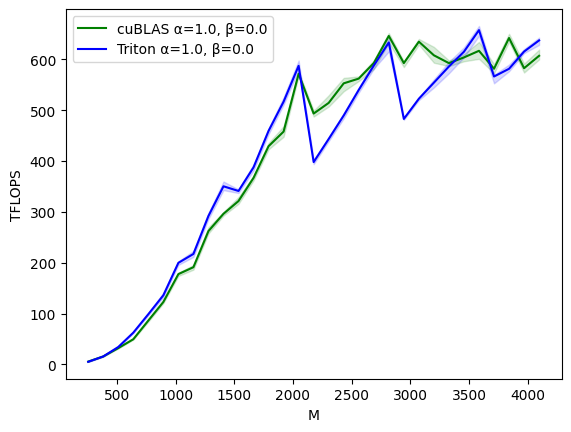

gemm-perf-fp16-a1.0-b0.0:
         M       N       K  cuBLAS α=1.0, β=0.0  Triton α=1.0, β=0.0
0    256.0   256.0   256.0             5.405031             4.922892
1    384.0   384.0   384.0            15.521684            15.453904
2    512.0   512.0   512.0            31.895849            34.100031
3    640.0   640.0   640.0            49.349398            62.296579
4    768.0   768.0   768.0            86.053349            98.646522
5    896.0   896.0   896.0           122.667657           135.823860
6   1024.0  1024.0  1024.0           177.536679           199.728763
7   1152.0  1152.0  1152.0           191.102967           217.162471
8   1280.0  1280.0  1280.0           262.143988           291.919813
9   1408.0  1408.0  1408.0           296.191564           350.314918
10  1536.0  1536.0  1536.0           321.265832           341.103040
11  1664.0  1664.0  1664.0           366.834638           387.570901
12  1792.0  1792.0  1792.0           429.190426           459.337876
13  1920

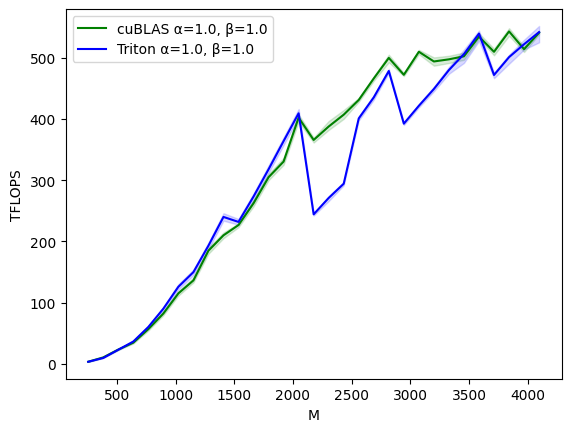

gemm-perf-fp16-a1.0-b1.0:
         M       N       K  cuBLAS α=1.0, β=1.0  Triton α=1.0, β=1.0
0    256.0   256.0   256.0             3.472106             3.426719
1    384.0   384.0   384.0            10.564012             9.642899
2    512.0   512.0   512.0            23.366596            23.045626
3    640.0   640.0   640.0            34.638478            36.489977
4    768.0   768.0   768.0            56.736575            60.237345
5    896.0   896.0   896.0            82.189576            90.095580
6   1024.0  1024.0  1024.0           115.109541           125.907816
7   1152.0  1152.0  1152.0           136.307404           149.767216
8   1280.0  1280.0  1280.0           184.868833           193.036822
9   1408.0  1408.0  1408.0           209.936024           239.968130
10  1536.0  1536.0  1536.0           226.719126           231.824379
11  1664.0  1664.0  1664.0           262.263378           273.211751
12  1792.0  1792.0  1792.0           304.797934           317.722232
13  1920

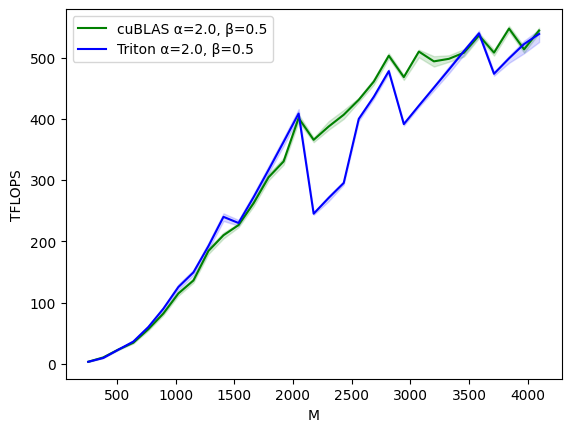

gemm-perf-fp16-a2.0-b0.5:
         M       N       K  cuBLAS α=2.0, β=0.5  Triton α=2.0, β=0.5
0    256.0   256.0   256.0             3.472106             3.426719
1    384.0   384.0   384.0            10.564012             9.642899
2    512.0   512.0   512.0            23.366596            23.109113
3    640.0   640.0   640.0            34.565401            36.408890
4    768.0   768.0   768.0            56.623101            60.109451
5    896.0   896.0   896.0            82.189576            90.005394
6   1024.0  1024.0  1024.0           114.912434           125.437129
7   1152.0  1152.0  1152.0           136.113233           149.299204
8   1280.0  1280.0  1280.0           184.348804           192.187680
9   1408.0  1408.0  1408.0           209.936024           239.968130
10  1536.0  1536.0  1536.0           226.492405           229.941527
11  1664.0  1664.0  1664.0           262.024738           271.921790
12  1792.0  1792.0  1792.0           304.539847           316.603483
13  1920

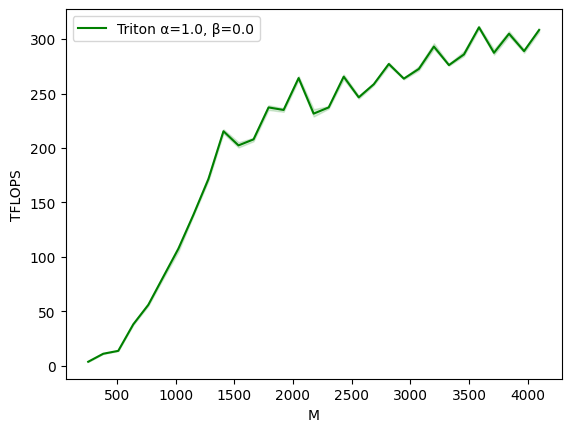

gemm-perf-fp8-a1.0-b0.0:
         M       N       K  Triton α=1.0, β=0.0
0    256.0   256.0   256.0             3.813004
1    384.0   384.0   384.0            11.163861
2    512.0   512.0   512.0            13.819782
3    640.0   640.0   640.0            38.191142
4    768.0   768.0   768.0            56.062479
5    896.0   896.0   896.0            81.890158
6   1024.0  1024.0  1024.0           107.546260
7   1152.0  1152.0  1152.0           138.681403
8   1280.0  1280.0  1280.0           171.560210
9   1408.0  1408.0  1408.0           215.378806
10  1536.0  1536.0  1536.0           202.406087
11  1664.0  1664.0  1664.0           207.917108
12  1792.0  1792.0  1792.0           237.243775
13  1920.0  1920.0  1920.0           234.927241
14  2048.0  2048.0  2048.0           264.208112
15  2176.0  2176.0  2176.0           231.555821
16  2304.0  2304.0  2304.0           237.247636
17  2432.0  2432.0  2432.0           265.472581
18  2560.0  2560.0  2560.0           246.491784
19  2688.0  268

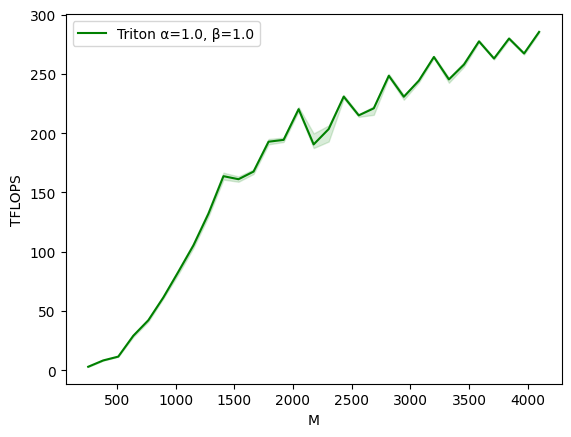

gemm-perf-fp8-a1.0-b1.0:
         M       N       K  Triton α=1.0, β=1.0
0    256.0   256.0   256.0             2.849391
1    384.0   384.0   384.0             8.192000
2    512.0   512.0   512.0            11.413072
3    640.0   640.0   640.0            28.998230
4    768.0   768.0   768.0            42.067685
5    896.0   896.0   896.0            61.333829
6   1024.0  1024.0  1024.0            83.004162
7   1152.0  1152.0  1152.0           105.232918
8   1280.0  1280.0  1280.0           131.995973
9   1408.0  1408.0  1408.0           163.655570
10  1536.0  1536.0  1536.0           161.089912
11  1664.0  1664.0  1664.0           167.519008
12  1792.0  1792.0  1792.0           192.744677
13  1920.0  1920.0  1920.0           194.276671
14  2048.0  2048.0  2048.0           220.209568
15  2176.0  2176.0  2176.0           190.463400
16  2304.0  2304.0  2304.0           203.409236
17  2432.0  2432.0  2432.0           230.814590
18  2560.0  2560.0  2560.0           214.960234
19  2688.0  268

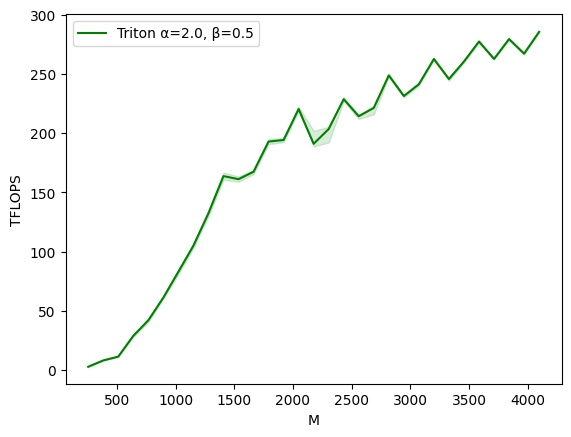

gemm-perf-fp8-a2.0-b0.5:
         M       N       K  Triton α=2.0, β=0.5
0    256.0   256.0   256.0             2.849391
1    384.0   384.0   384.0             8.192000
2    512.0   512.0   512.0            11.413072
3    640.0   640.0   640.0            28.946996
4    768.0   768.0   768.0            42.067685
5    896.0   896.0   896.0            61.250267
6   1024.0  1024.0  1024.0            83.055527
7   1152.0  1152.0  1152.0           105.059360
8   1280.0  1280.0  1280.0           132.395963
9   1408.0  1408.0  1408.0           163.809238
10  1536.0  1536.0  1536.0           161.204568
11  1664.0  1664.0  1664.0           167.421624
12  1792.0  1792.0  1792.0           192.951486
13  1920.0  1920.0  1920.0           194.276671
14  2048.0  2048.0  2048.0           220.480875
15  2176.0  2176.0  2176.0           191.085082
16  2304.0  2304.0  2304.0           203.544638
17  2432.0  2432.0  2432.0           228.758987
18  2560.0  2560.0  2560.0           214.345053
19  2688.0  268

In [7]:
import torch
import triton
import triton.language as tl

ref_lib = 'cuBLAS' if is_cuda() else 'rocBLAS'
TORCH_HAS_FP8 = hasattr(torch, 'float8_e5m2') and hasattr(torch, 'float8_e4m3fn')

alpha_beta_configs = [
    (1.0, 0.0),    
    (1.0, 1.0),    
    (2.0, 0.5),  
]

configs = []
for fp8_inputs in [False, True]:
    if fp8_inputs and (not TORCH_HAS_FP8 or not is_cuda()):
        continue
    for alpha, beta in alpha_beta_configs:
        configs.append(
            triton.testing.Benchmark(
                x_names=["M", "N", "K"],
                x_vals=[128 * i for i in range(2, 33)],
                line_arg="provider",
                line_vals=["triton"] if fp8_inputs else [ref_lib.lower(), "triton"],
                line_names=[f"Triton α={alpha}, β={beta}"] if fp8_inputs else 
                          [f"{ref_lib} α={alpha}, β={beta}", f"Triton α={alpha}, β={beta}"],
                styles=[("green", "-"), ("blue", "-")],
                ylabel="TFLOPS",
                plot_name=f"gemm-perf-{'fp8' if fp8_inputs else 'fp16'}-a{alpha}-b{beta}",
                args={"fp8_inputs": fp8_inputs, "alpha": alpha, "beta": beta},
            ))

@triton.testing.perf_report(configs)
def benchmark(M, N, K, provider, fp8_inputs, alpha, beta):
    a = torch.randn((M, K), device=DEVICE, dtype=torch.float16)
    b = torch.randn((K, N), device=DEVICE, dtype=torch.float16)
    c_initial = torch.randn((M, N), device=DEVICE, dtype=torch.float16)
    
    if fp8_inputs:
        a = a.to(torch.float8_e5m2)
        b = b.to(torch.float8_e5m2)

    quantiles = [0.5, 0.2, 0.8]
    
    if provider == ref_lib.lower():
        if fp8_inputs:
            return 0, 0, 0  
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: torch.addmm(c_initial, a, b, beta=beta, alpha=alpha), 
            quantiles=quantiles
        )
    elif provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: gemm(a, b, c_initial, alpha, beta), 
            quantiles=quantiles
        )

    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)

benchmark.run(show_plots=True, print_data=True)